![title](images/header.png)
# VI - Calculating areas of change and confidence intervals
-------
This notebook estimates of areas of change for all categories using the entire database of systematic points, and calculates the margin of error based on the visually interpreted data 
This script requires a m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

### 1 - Read files and set parameters
read the output merged file with the classification of all eSBAE points from script 5e

In [2]:
#GAB
df = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_supervised_class_1522.csv', low_memory=False)
#DRC
#df = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_supervised_class_1522.csv', low_memory=False)
#COG
#df = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_supervised_class_1522.csv', low_memory=False)
#CMR
#df = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_supervised_class_1522.csv', low_memory=False)
#EQG
#df = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_supervised_class_1522.csv', low_memory=False)
#CAR
#df = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_esbae_supervised_class_1522.csv', low_memory=False)

In [3]:
print(df.columns.values)

['Unnamed: 0' 'images' 'mon_images' 'bfast_change_date' 'bfast_magnitude'
 'bfast_means' 'cusum_change_date' 'cusum_confidence' 'cusum_magnitude'
 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean' 'nir_sd' 'nir_min'
 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min' 'swir1_max' 'swir2_mean'
 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean' 'ndfi_sd' 'ndfi_min'
 'ndfi_max' 'brightness_mean' 'brightness_sd' 'brightness_min'
 'brightness_max' 'greenness_mean' 'greenness_sd' 'greenness_min'
 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min' 'wetness_max'
 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ccdc_change_date' 'ccdc_magnitude' 'aspect' 'dw_class_mode'
 'dw_tree_prob__max' 'dw_tree_prob__min' 'dw_tree_prob__stdDev'
 'dw_tree_prob_mean' 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17'
 'esri_lc18' 'esri_lc19' 'esri_lc20' 'esri_lc21' 'gfc_gain' 'gfc_loss'
 'gfc_lossyear' 'gfc_tc00' 'lang_tree_height' 'potapov_tree_height'
 'slope' 'tmf_2016' 'tmf_2017' 'tmf_2018' 'tmf_

In [4]:
print(len(df))

222878


In [5]:
# use these strata counts for area estimation with Excel
strata_counts = df['stratum'].value_counts().sort_index()
print(strata_counts)

1    169047
2     43683
3     10148
Name: stratum, dtype: int64


In [ ]:
pd.pivot_table(df,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['interpreted'],aggfunc="count")

In [6]:
def calculate_areas(db_total, strata_column, categories_column, interpretation_column, total_area, z_score):
    
    df_full = db_total.copy()
    df_interpreted = db_total[db_total[interpretation_column]==1]
    df_4calc       = db_total[~db_total[categories_column].isna()]
    
    # get all attributes
    categories = df_4calc[categories_column].unique()
    
    # get strata
    strata, d = df_4calc[strata_column].unique(), {}
    print(categories)
    # create stats for each entry
    for category in categories:
        
        if str(category) == 'nan':
            continue
            
        print(f' Calculating stats for {category}')
        # create binary class column
        df_4calc[category] =  df_4calc[categories_column].apply(lambda x: 1 if x == category else 0)
        df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)
        
        print(f'We use {df_4calc[category].sum()} entries for area calculation of {category} in {categories_column}.')
        print(f'We use {df_interpreted[category].sum()} entries for margin of error calculation of {category} in {categories_column}.')
        
        # initialize variables for category <> check the catergories > def, deg, gain
        categories_area, se_total = 0, 0
        d2 = {}
        for stratum in strata:
                        
            if str(stratum) == 'nan':
                continue
            
            # subset to stratum
            df_stratum = df_full[df_full[strata_column] == stratum]
            
            # get area proportion for that stratum on full dataset
            proportion_strata = len(df_stratum)/len(df_full)

            # get stratum area
            stratum_area = proportion_strata * total_area

            # get proportion of forest change within strata from interpreted data
            proportion_category = len(
                df_4calc[(df_4calc[strata_column] == stratum) & (df_4calc[category] == 1)]
            ) / len(
                df_4calc[df_4calc[strata_column] == stratum]
            )
            
            # get area from proportion and full area
            category_stratum_area = proportion_category * stratum_area

            # get error from interpreted data for full stratum area
            var = np.var(df_interpreted[category][df_interpreted[strata_column] == stratum])
            sd = np.sqrt(var)               
            n = len(df_interpreted[df_interpreted[strata_column] == stratum])
            se = sd/np.sqrt(n) * stratum_area
                          
            # add for totals
            categories_area += category_stratum_area
            se_total += se**2
            
            # add to dictionary
            d2[f'area_stratum_{stratum}'] = category_stratum_area
            d2[f'ci_stratum_{stratum}']=z_score*se
        
        d2['area_total'] = categories_area
        d2['MOE'] = z_score*np.sqrt(se_total)
        d2['MOE_perc'] =  d2['MOE'] / categories_area * 100
        d[category] = d2
    
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # Create the pivot table
    pivot_table = pd.pivot_table(df_full, values='point_id', index=[strata_column], columns=[categories_column], aggfunc="count", dropna=False)

    # Sort the index
    pivot_table = pivot_table.sort_index()

    # Print the sorted pivot table
    print(pivot_table)
    #print(pd.pivot_table(df_full,values='point_id',index=[strata_column],columns=[categories_column],aggfunc="count",dropna= False))
    
    return pd.DataFrame.from_dict(d, orient='index')

### Enter Parameters

###### country area (ha)
###### GAB = 26287600
###### DRC = 232798200
###### COG = 34402400
###### CMR = 46497000
###### EQG = 2685800
###### CAR = 62009300

In [7]:
z_score = 1.647
db_total = df
strata_column = 'stratum'
#categories_column = 'Sim_CEO_Ref_Change_Type_1522' # general change classes
categories_column = 'Sim_CEO_Ref_Change_Year_1522' #detailed change classes with years
interpretation_column = 'interpreted'
total_area = 26287600 #enter area from above

In [8]:
calculate_areas(db_total, 
                strata_column, 
                categories_column, 
                interpretation_column,
                total_area,
                z_score)

['Stable' 'NF' 'Deg2019' 'Deg2018' 'Deg2017' 'Def2022' 'Def2020' 'Deg2016'
 'Deg2020' 'Deg2022' 'Deg2021' 'Def2021' 'Def2016' 'Def2017' 'Def2018'
 'Def2019']
 Calculating stats for Stable
We use 6718 entries for area calculation of Stable in Sim_CEO_Ref_Change_Year_1522.
We use 6718 entries for margin of error calculation of Stable in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for NF
We use 1366 entries for area calculation of NF in Sim_CEO_Ref_Change_Year_1522.
We use 1366 entries for margin of error calculation of NF in Sim_CEO_Ref_Change_Year_1522.


/tmp/ipykernel_3182/680078543.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4calc[category] =  df_4calc[categories_column].apply(lambda x: 1 if x == category else 0)
/tmp/ipykernel_3182/680078543.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2019
We use 20 entries for area calculation of Deg2019 in Sim_CEO_Ref_Change_Year_1522.
We use 20 entries for margin of error calculation of Deg2019 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2018
We use 30 entries for area calculation of Deg2018 in Sim_CEO_Ref_Change_Year_1522.
We use 30 entries for margin of error calculation of Deg2018 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2017
We use 20 entries for area calculation of Deg2017 in Sim_CEO_Ref_Change_Year_1522.
We use 20 entries for margin of error calculation of Deg2017 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2022
We use 14 entries for area calculation of Def2022 in Sim_CEO_Ref_Change_Year_1522.
We use 14 entries for margin of error calculation of Def2022 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2020
We use 7 entries for area calculation of Def2020 in Sim_CEO_Ref_Change_Year_1522.
We use 7 entries for margin of error calculation of Def

,area_stratum_2,ci_stratum_2,area_stratum_3,ci_stratum_3,area_stratum_1,ci_stratum_1,area_total,MOE,MOE_perc
Stable,4480085.45,38878.91,773102.71,18258.71,19543620.67,262829.86,24796808.82,266316.52,1.07
NF,631159.09,37846.57,313371.48,16784.48,394820.62,262829.86,1339351.19,266070.70,19.87
Deg2019,953.41,1570.13,8530.17,3211.60,0.00,0.00,9483.58,3574.87,37.70
Deg2018,2860.24,2719.03,12121.82,3822.69,0.00,0.00,14982.06,4691.07,31.31
Deg2017,953.41,1570.13,8530.17,3211.60,0.00,0.00,9483.58,3574.87,37.70
Def2022,5720.48,3844.23,3591.65,2088.29,0.00,0.00,9312.13,4374.82,46.98
Def2020,953.41,1570.13,2693.74,1809.19,0.00,0.00,3647.15,2395.51,65.68
Deg2016,1906.83,2220.29,6734.34,2855.74,0.00,0.00,8641.17,3617.31,41.86
Deg2020,5720.48,3844.23,15713.47,4345.72,0.00,0.00,21433.94,5802.01,27.07
Deg2022,11440.95,5433.53,17060.34,4525.56,0.00,0.00,28501.29,7071.35,24.81


### plot areas with error bars

In [33]:
# what is the output table called?? 

#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
Def_areas = pivot_table[pivot_table['index'].isin(values_to_plot)]

# Create a bar chart
ax = Def_areas.plot(kind='bar', x='ChangeYear', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Def_areas['ChangeYear'], Def_areas['area_total'], yerr=Def_areas['ci_total'], capsize=5)  # Add error bars

# Show the plot
plt.show()

NameError: name 'pivot_table' is not defined

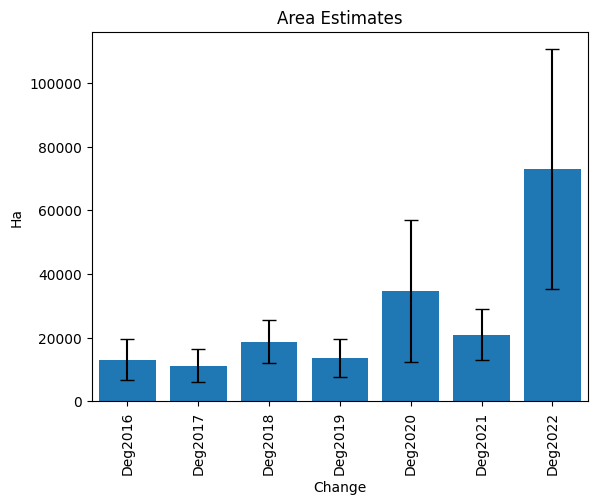

In [ ]:
#plot DEG 
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
Deg_areas = stats_df[stats_df['ChangeYear'].isin(values_to_plot)]

# Create a bar chart
ax = Deg_areas.plot(kind='bar', x='ChangeYear', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Deg_areas['ChangeYear'], Deg_areas['area_total'], yerr=Deg_areas['ci_total'], capsize=5)  # Add error bars
# Show the plot
plt.show()

### export stats to csv

In [ ]:
grouped_out =  '/home/sepal-user/module_results/esbae/GAB/GAB_total_stats_2015_2022.csv'
stats_gdf.to_csv(grouped_out,index=True)

In [ ]:
annual_out =  '/home/sepal-user/module_results/esbae/GAB/GAB_annual_stats_2015_2022.csv'
stats_df.to_csv(annual_out,index=True)